<a href="https://colab.research.google.com/github/Emsh1379/Finger_Flex_Project/blob/main/Finger_flex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Data retrieval
import os, requests

fname = 'fingerflex.npz'
url = "https://osf.io/5m47z/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet
!pip install multitaper --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
from matplotlib import gridspec

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.

In [ ]:
# @title Data loading
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
from sklearn import preprocessing
from scipy import signal
import multitaper.mtspec as spec
import multitaper.utils as utils

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]
print(dat.keys())

dict_keys(['V', 'dg', 't_on', 't_off', 'stim_id', 'stimtext', 'srate', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [ ]:
# @title Name it or set it
V_raw = dat['V'].astype('float32')
dg = dat['dg']
ndigits = dg.shape[1]
stim_id = dat['stim_id']
t_on = dat['t_on']
t_off = dat['t_off']
nt, nchan = V_raw.shape
nfingers = dg.shape[1]
dig = 0
ch = 0
t = 150000
fs = 1000
#print(nt, nfingers, nchan)

In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [ ]:
#Edited Version for electrode:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']

# Convert the locs to MNI space
mni_locs = utils.tal2mni(locs)

# Initialize marker colors as purple for all markers
marker_colors = ['blue'] * locs.shape[0]

# Select indices of the markers you want to color differently (motor cortical Area)
selected_marker_indices = [19,20, 21]

# Set the color of the selected markers to blue
for idx in selected_marker_indices:
    marker_colors[idx] = 'red'

# Plot the markers with different colors
view = plotting.view_markers(mni_locs,
                             marker_labels=['%d' % k for k in np.arange(locs.shape[0])],
                             marker_color=marker_colors,
                             marker_size=5)

view


<Figure size 800x800 with 0 Axes>

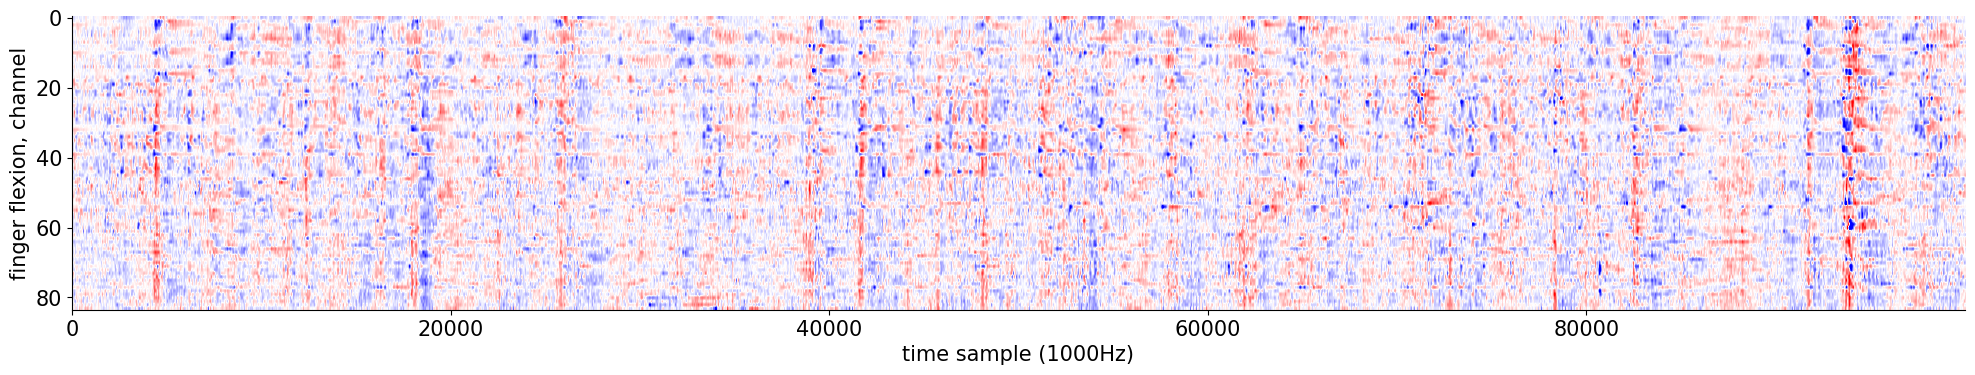

In [ ]:
# @title Look at some raw data
plt.imshow(V_raw[:100000, :].T,
           aspect='auto',
           vmax=4,
           vmin=-4,
           cmap='bwr')

plt.xlabel('time sample (1000Hz)')
plt.ylabel('finger flexion, channel')
plt.show()

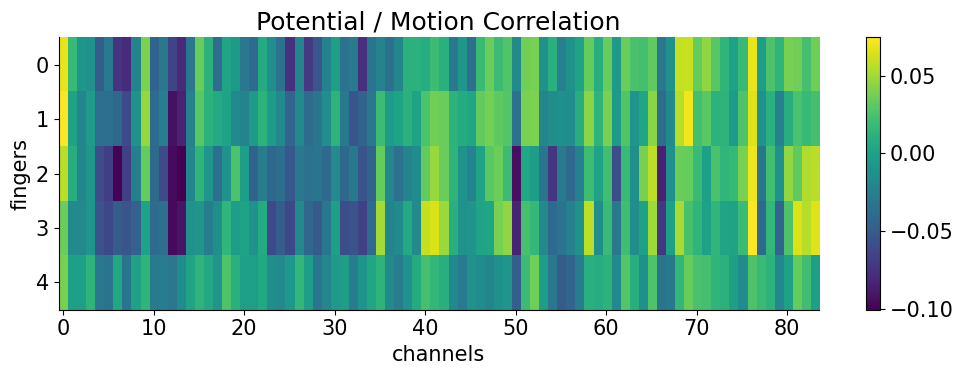

In [ ]:

cc = np.zeros((nchan,nfingers))
for j in range(nchan):
  for k in range(nfingers):
    cc[j, k] = np.corrcoef(V_raw[:, j], dg[:, k])[0, 1]
plt.subplot(1, 2, 1)
plt.imshow(cc.T, aspect='auto')
plt.colorbar()
plt.xlabel('channels')
plt.ylabel('fingers')
plt.title('Potential / Motion Correlation')
plt.show()

Text(0, 0.5, 'finger movement')

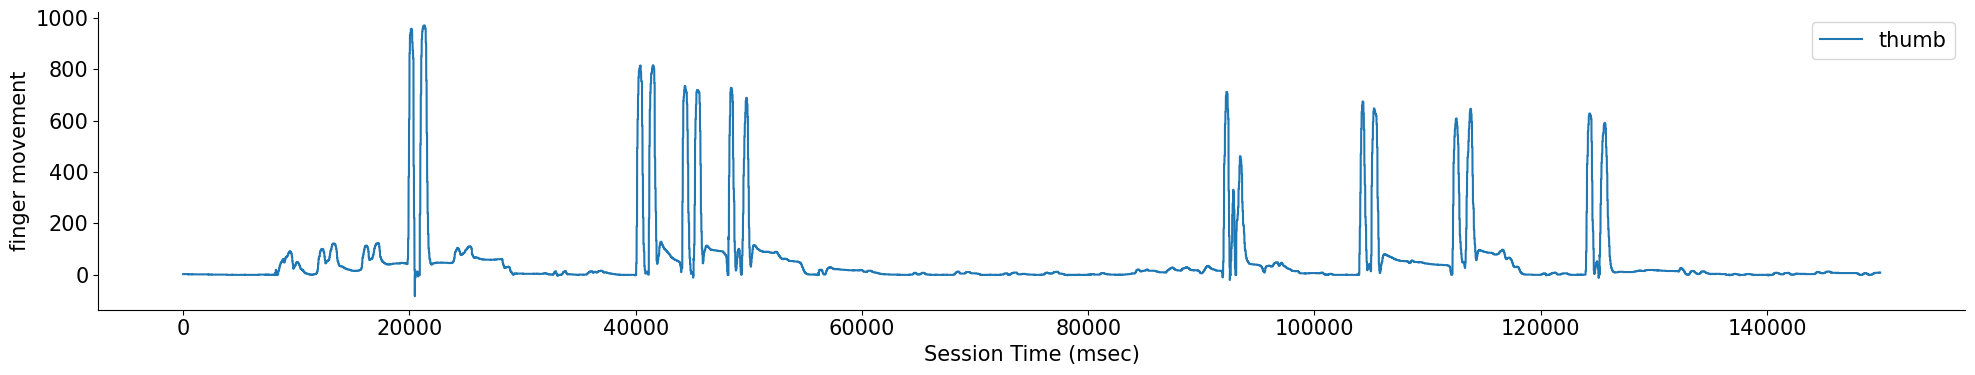

In [ ]:
# @title Look at this __thumb__
plt.plot(dg[:t, dig])
plt.legend(dat['stimtext'])
plt.xlabel('Session Time (msec)')
plt.ylabel('finger movement')

Text(0, 0.5, '12- 20 Hz oscillations (voltage)')

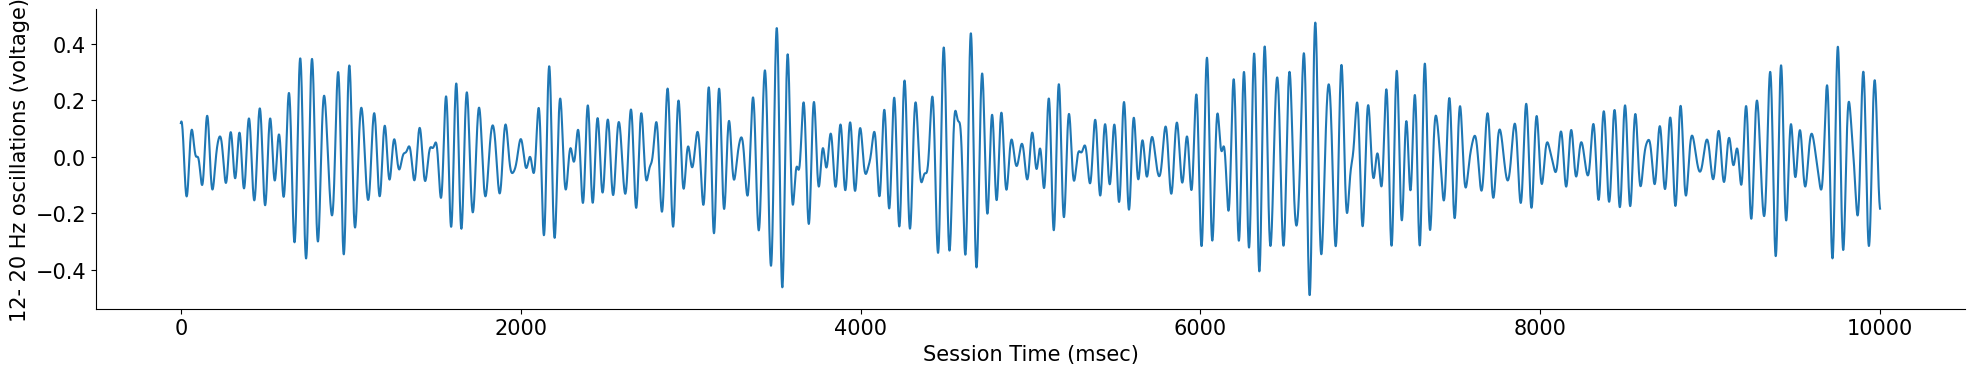

In [ ]:
# @title __it's beta__ (should be, at least)
# trying to get the beta-rhythm-related voltage
ch = 0
dig = 0

# Filter raw signal to above 50 Hz
b, a = signal.butter(3, (12,20), btype='bandpass', fs=1000)
V_m_bp= signal.filtfilt(b, a, V_raw[:], 0)
plt.plot(V_m_bp[:10000, ch])
plt.xlabel('Session Time (msec)')
plt.ylabel('12- 20 Hz oscillations (voltage)')

Text(0, 0.5, 'amplitude')

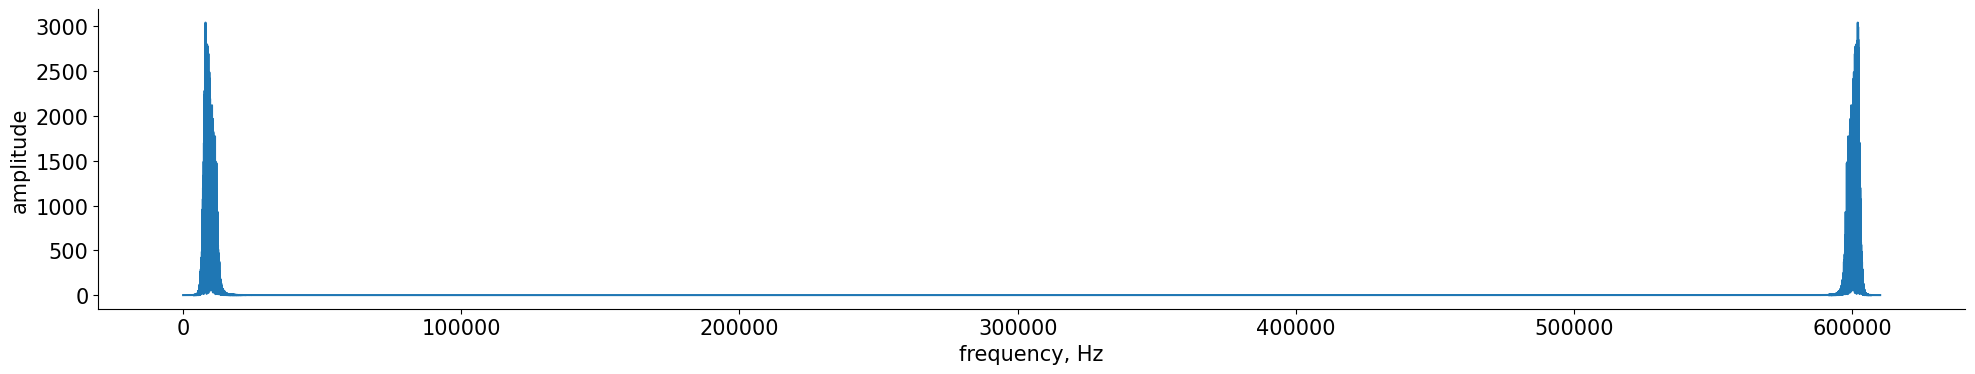

In [ ]:
#@title I've got questions
y = fft(V_m_bp[:, ch])
plt.figure()
plt.plot(np.abs(y[:]))
plt.xlabel('frequency, Hz') #it's not Hz
plt.ylabel('amplitude')

Text(0, 0.5, 'broadband signal amplitude')

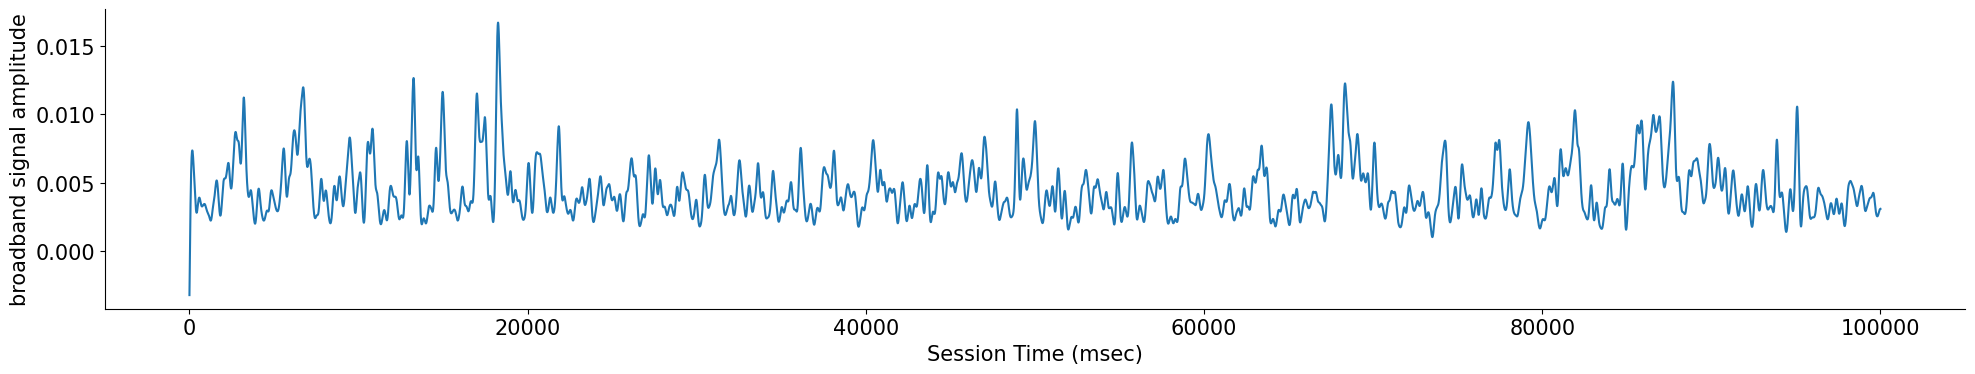

In [ ]:
# @title Trying to get the broadband signal
# Find the envelope of power ("local variance") in the high band
# Use  pass to band of interest -> rectify -> low pass signal chain

# Filter raw signal to above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
#print(b, a)
V_high = signal.filtfilt(b, a, V_raw, 0)

# Rectify
V_rect = np.abs(V_high)**2

#var_estimated = np.mean(V_rect) # Approximate

# Smooth to find envelope in high band
b, a = signal.butter(3, [3], btype='low', fs=1000)
V_envelope = signal.filtfilt(b, a, V_rect, 0)

V_bb = V_envelope
plt.plot(V_bb[:100000, ch])

plt.xlabel('Session Time (msec)')
plt.ylabel('broadband signal amplitude')

How getting the envelope works

Text(0, 0.5, 'voltage')

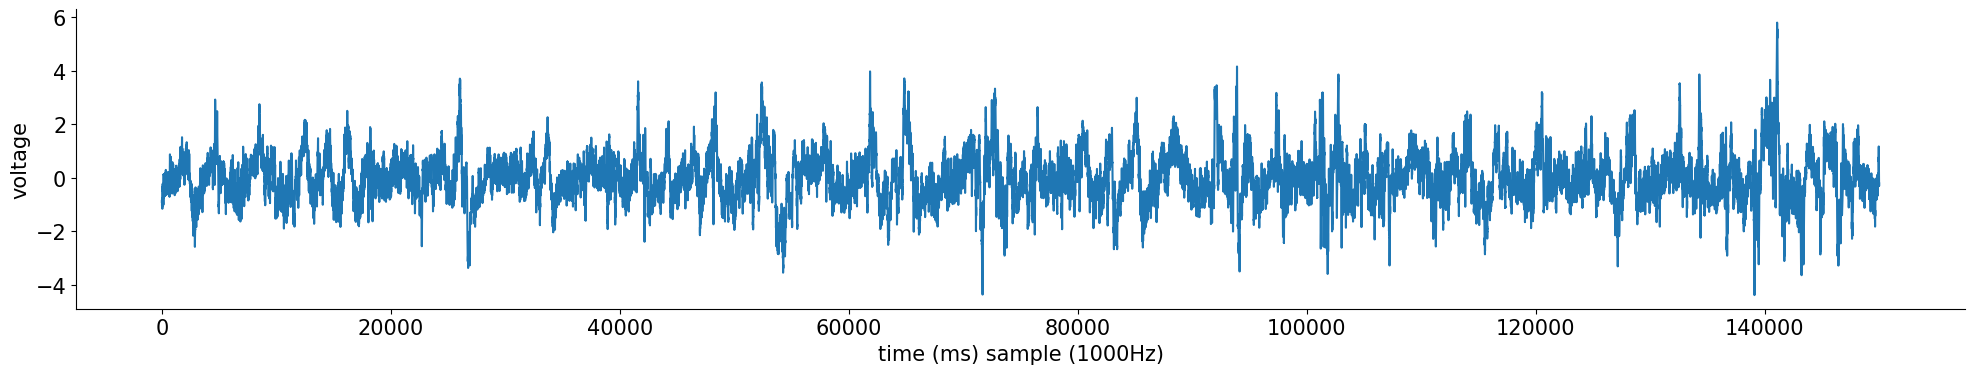

In [ ]:
plt.plot(V_raw[:t, ch])
plt.xlabel('time (ms) sample (1000Hz)')
plt.ylabel('voltage')

Text(0, 0.5, 'V_high')

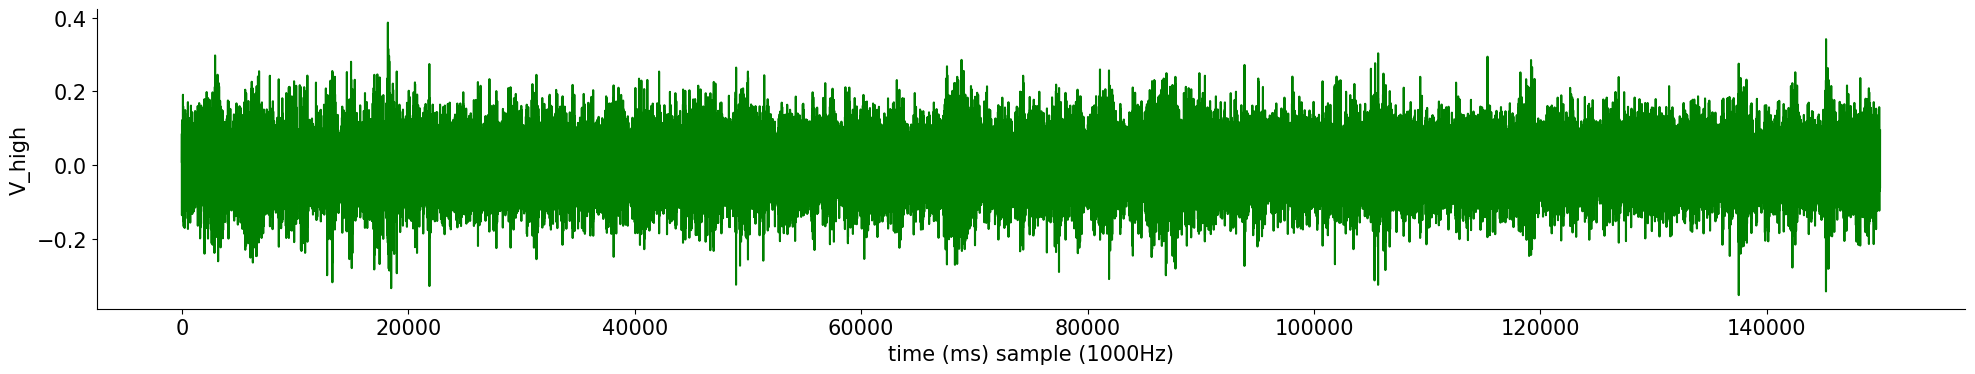

In [ ]:
plt.plot(V_high[:t, ch], 'g')
plt.xlabel('time (ms) sample (1000Hz)')
plt.ylabel('V_high')

Text(0, 0.5, 'V_rect')

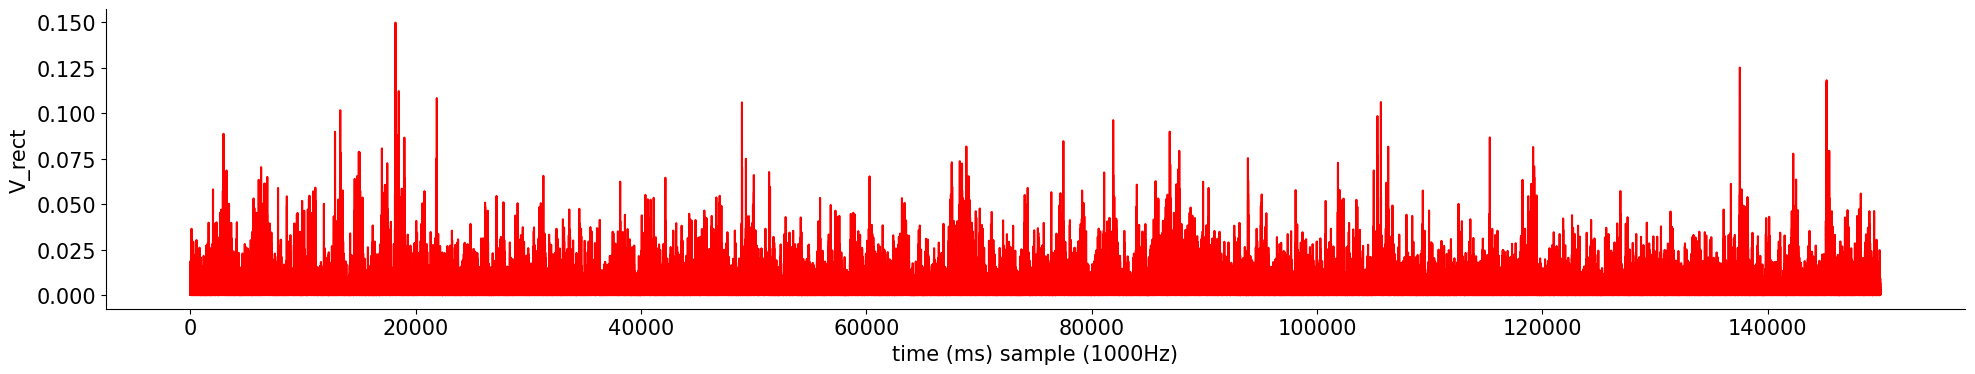

In [ ]:
plt.plot(V_rect[:t, ch], 'r')
plt.xlabel('time (ms) sample (1000Hz)')
plt.ylabel('V_rect')

Text(0, 0.5, 'power_high')

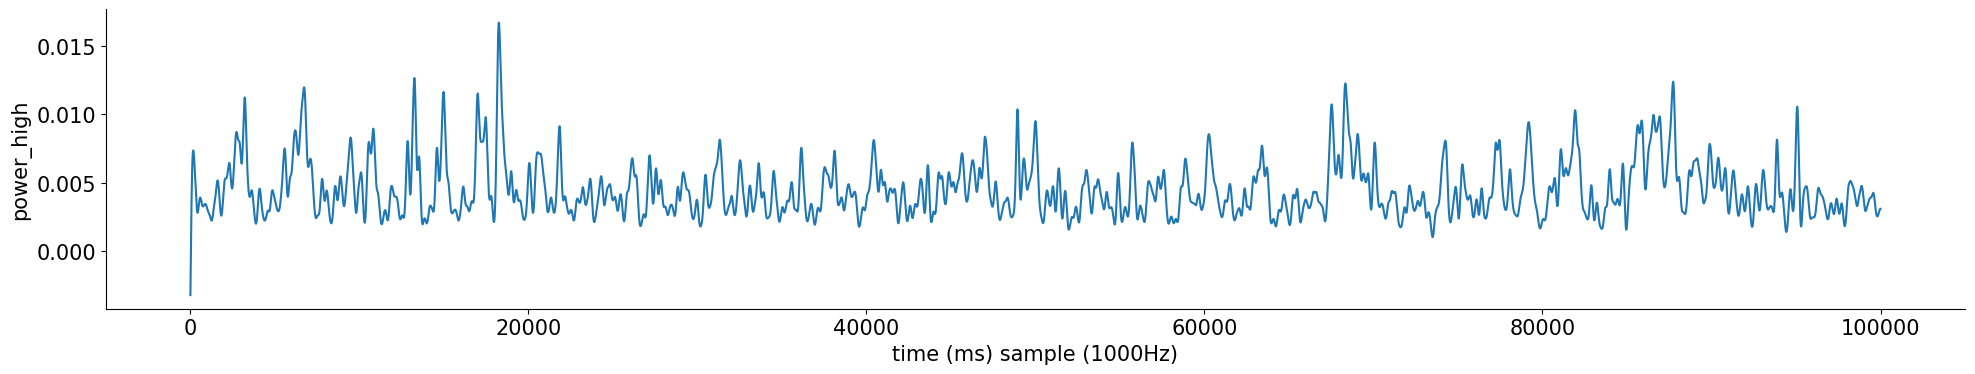

In [ ]:
power_high = V_envelope
plt.plot(power_high[:100000, ch])
plt.xlabel('time (ms) sample (1000Hz)')
plt.ylabel('power_high')

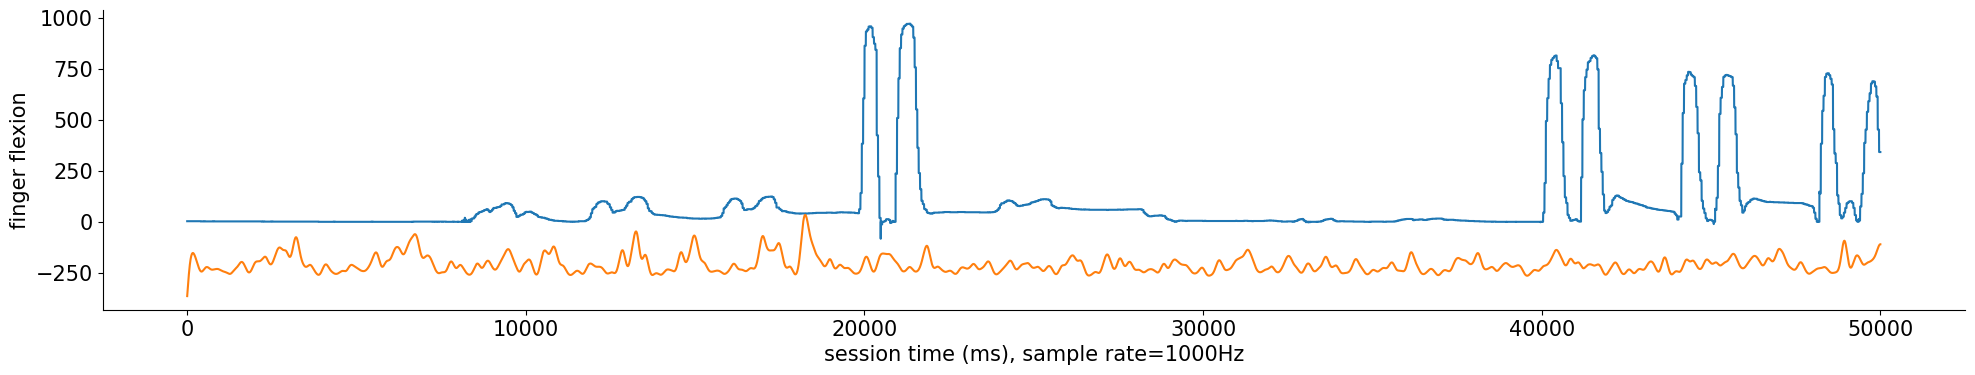

In [ ]:
# @title broadband vs finger flexion (I've got questions #2)
plt.plot(dg[:50000, dig])
plt.plot(V_bb[:50000, ch]*20000 - 300)
plt.xlabel('session time (ms), sample rate=1000Hz')
plt.ylabel('finger flexion')
#plt.xlim([0, 100000])
plt.show()
#might be the wrong electrode, so we have to find the reference electrode first

<Figure size 4000x4000 with 0 Axes>

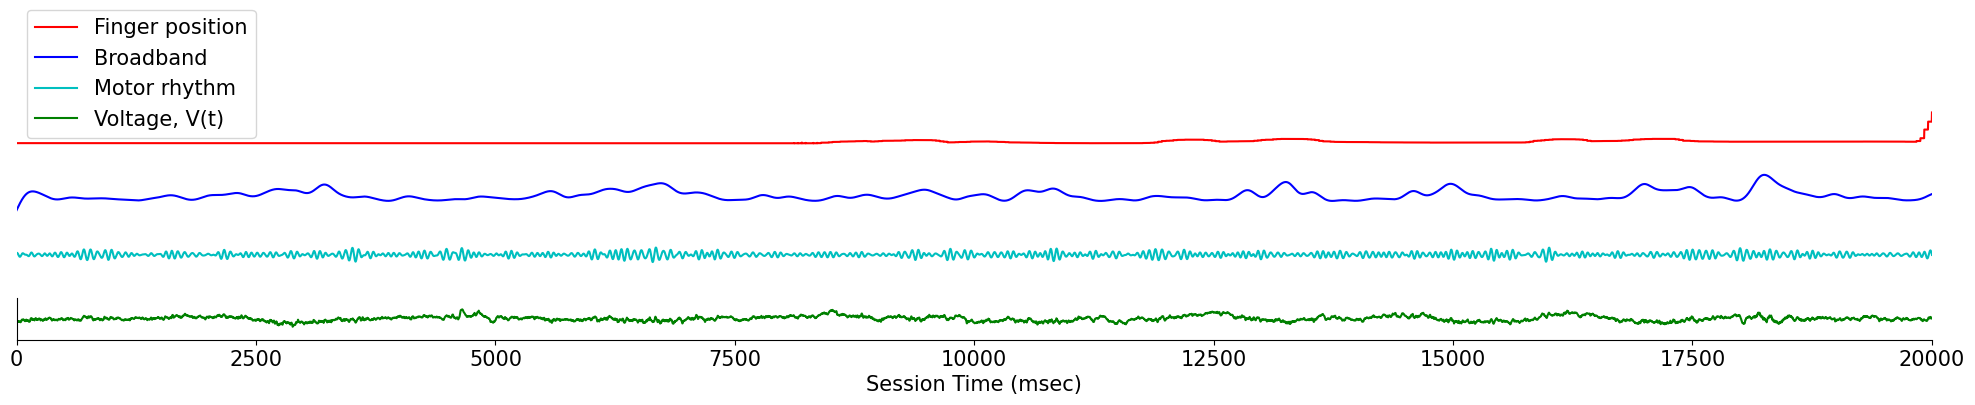

In [ ]:
# @title fig 1D
#1st row: finger position (thumb, in this case)
#2nd row: broadband
#3rd row: motor rhythm
#4th row: Voltage (from one electrode)

from matplotlib import gridspec

# Simple data to display in various forms
plt.figure(figsize = (40, 40))
x_start = 0
x_finish =20000


label0='Finger position'
label1='Broadband'
label2='Motor rhythm'
label3='Voltage, V(t)'

fig = plt.figure()
# set height ratios for subplots
gs = gridspec.GridSpec(4, 1)

# the first subplot
ax0 = plt.subplot(gs[0])
ax0.set_axis_off() #tuning the y axis off
line0, = ax0.plot(dg[:, dig], color='r')


# the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
line1, = ax1.plot(V_envelope[:, ch], color='b')
#ax1.get_xaxis().set_visible(False)
ax1.set_axis_off()


# the third subplot
# shared axis X
ax2 = plt.subplot(gs[2], sharex = ax0)
line2, = ax2.plot(V_m_bp[:, ch], color='c')
#ax2.get_xaxis().set_visible(False)
ax2.set_axis_off()



# the fourth subplot
# shared axis X
ax3 = plt.subplot(gs[3], sharex = ax0)
line3, = ax3.plot(V_raw[:, ch], color='g')
plt.setp(ax3.get_yaxis(), visible = False)
# remove last tick label for the 4th subplot
yticks = ax3.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# put legend on first subplot

# remove vertical gap between subplots
ax0.legend([line0, line1, line2, line3], [label0, label1, label2, label3],  loc='best')
plt.xlabel('Session Time (msec)')
plt.subplots_adjust(hspace=.1)
plt.xlim(x_start, x_finish)
plt.show()

**Cutting the data into chunks that contain finger movement (I need a better method, please help)**

In [ ]:
v_m_on = np.zeros_like(V_raw[:, ch])
v_r_on = np.zeros_like(V_raw[:, ch])
value = True
t_m_on = [(t_on[i] + 500) for i in range(len(t_on))]
t_m_off = [(t_off[i] + 1200) for i in range(len(t_off))]
for i, v in enumerate(v_m_on):
  if i in t_m_on:
    value = True
  if i in t_m_off:
    value = False
  v_m_on[i] = value

Text(0.5, 1.0, 'Trial number 150')

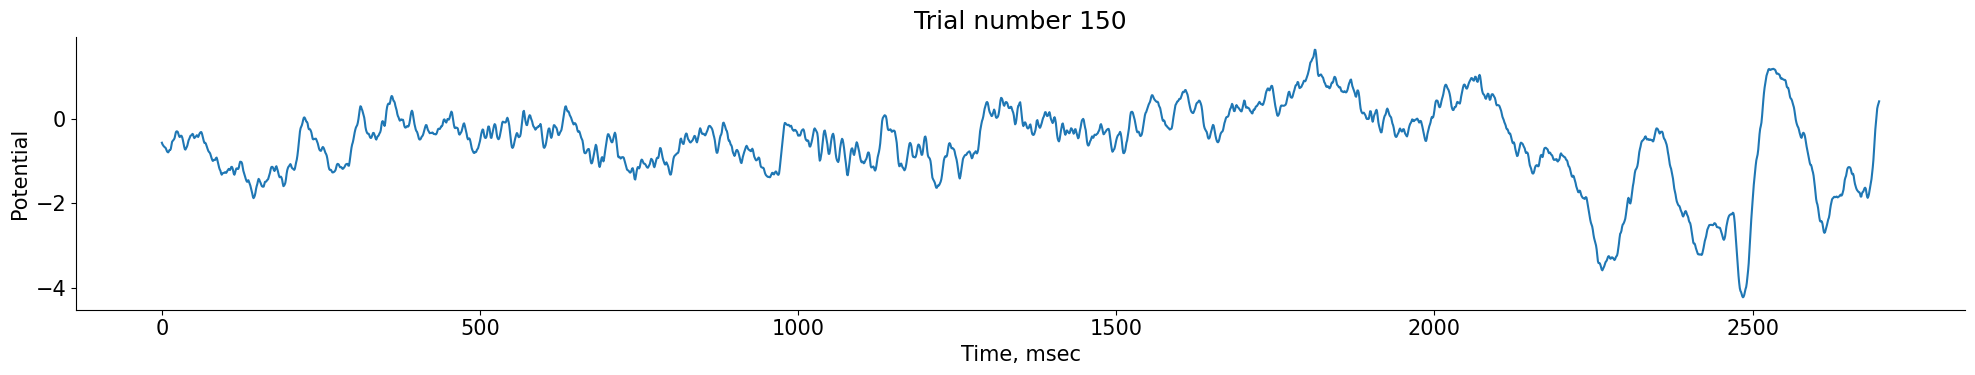

In [ ]:
trial_num = len(t_m_on) - 1
plt.plot(V_raw[t_m_on[trial_num]:t_m_off[trial_num], ch])
plt.xlabel('Time, msec')
plt.ylabel('Potential')
plt.title(f'Trial number {trial_num + 1}')

(1, 100000.0)

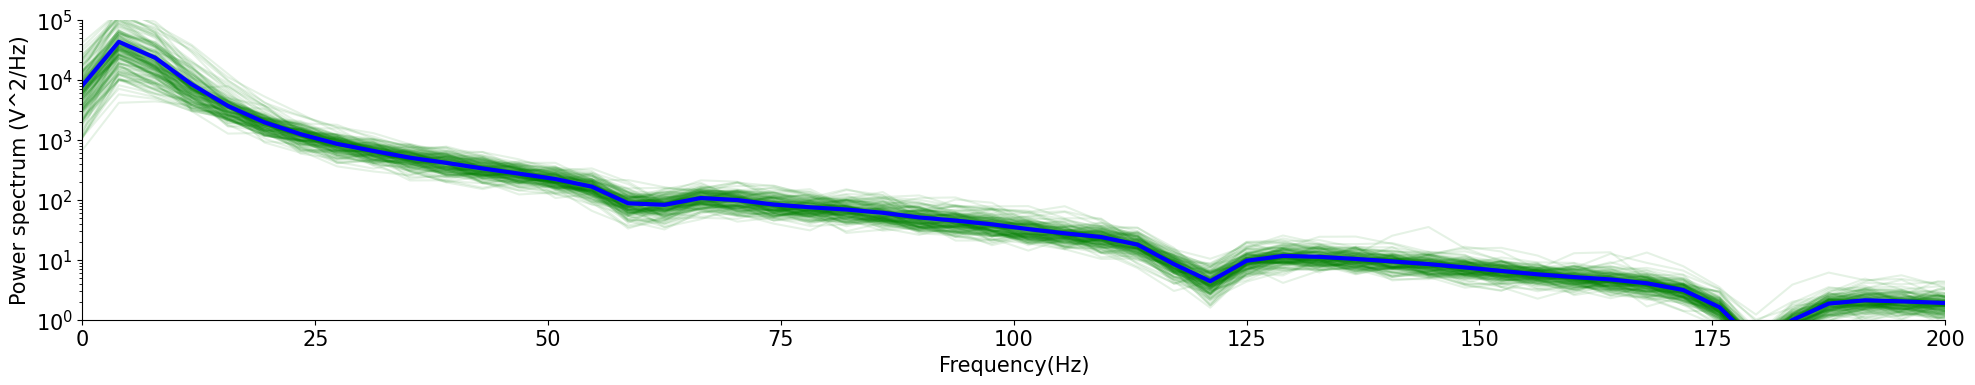

In [ ]:
trials = trial_num + 1
All_S = np.zeros((trials, 129))
print()

for cur_trial in range(trials):
  V_trial = V_raw[t_m_on[cur_trial]:t_m_off[cur_trial], ch]
  #V_hat = fft(V_trial)
  (f, S)= signal.welch(V_trial*1000, fs=1000)
  All_S[cur_trial, :] = S
  plt.semilogy(f, S, 'g', alpha=0.1)
  #All_S=np.(S, All_S, axis=0)
Mean_S = np.mean(All_S, axis=0)
plt.plot(f, Mean_S, linewidth =3, color ='b')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Power spectrum (V^2/Hz)')
plt.xlim(0, 200)
plt.ylim(1, 1e5 )
#work backwards
#try cnb
#name the slides properly
#uvolts**2/hz try latex
#examine the trials, clean up the figure

In [ ]:
print(np.var(V_trial))
print(np.sum(S)/2700)

0.8377604
42.17347511574074


In [ ]:
'''trials = trial_num + 1
Average_S = np.zeros_like(129)

for cur_trial in range(trials):
  V_trial = V_raw[t_m_on[cur_trial]:t_m_off[cur_trial], ch]
  V_hat = fft(V_trial)
  (f, S)= signal.welch(V_trial, fs=1000)
  Average_S += S

#calculate the average by dividing number of trials
Average_S /= trials
plt.semilogy(f, S)
#plt.xlim(0,200)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Averaged Power Spectral Density across Trials')


#print(S)
#print(trials)'''

"trials = trial_num + 1\nAverage_S = np.zeros_like(129)\n\nfor cur_trial in range(trials):\n  V_trial = V_raw[t_m_on[cur_trial]:t_m_off[cur_trial], ch]\n  V_hat = fft(V_trial)\n  (f, S)= signal.welch(V_trial, fs=1000)\n  Average_S += S\n\n#calculate the average by dividing number of trials\nAverage_S /= trials\nplt.semilogy(f, S)\n#plt.xlim(0,200)\nplt.xlabel('Frequency (Hz)')\nplt.ylabel('Power Spectral Density')\nplt.title('Averaged Power Spectral Density across Trials')\n\n\n#print(S)\n#print(trials)"

In [ ]:
'''t_ax = t_m_off[0] - t_m_on[0]
for cur_trial in range(trial_num):
  V_trial = V_raw[t_m_on[cur_trial]:t_m_off[cur_trial], ch]
  Power = np.abs(V_trial)**2
  Power_hat = fft(Power)
  #Power_hat = np.fft.fft(Power)
  freq = np.fft.fftfreq(t_ax)
  plt.semilogy(Power_hat)
  #plt.plot(freq, (Power_hat.real**2 + Power_hat.imag**2)**0.5)
  #print(Power_hat)
  #plt.semilogy(freq, Power_hat)
  #fft
  #power spectrum (np.abs(v)**2))
  #V_hat = FFT(V_trial)
  #V_fft
  #average the power spectra
  #np.array(power_spectra_list)
  #check the dimensions

  # another method
  #np.full(np.nan, DIMENSIONS) # pre-allocate ~does not matter much here, but we have to be aware of it
  # plt.imshow() see the difference (heatmap, trial-to-trial)
  #try multitaper instead of raw fft'''

't_ax = t_m_off[0] - t_m_on[0]\nfor cur_trial in range(trial_num):\n  V_trial = V_raw[t_m_on[cur_trial]:t_m_off[cur_trial], ch]\n  Power = np.abs(V_trial)**2\n  Power_hat = fft(Power)\n  #Power_hat = np.fft.fft(Power)\n  freq = np.fft.fftfreq(t_ax)\n  plt.semilogy(Power_hat)\n  #plt.plot(freq, (Power_hat.real**2 + Power_hat.imag**2)**0.5)\n  #print(Power_hat)\n  #plt.semilogy(freq, Power_hat)\n  #fft\n  #power spectrum (np.abs(v)**2))\n  #V_hat = FFT(V_trial)\n  #V_fft\n  #average the power spectra\n  #np.array(power_spectra_list)\n  #check the dimensions\n\n  # another method\n  #np.full(np.nan, DIMENSIONS) # pre-allocate ~does not matter much here, but we have to be aware of it\n  # plt.imshow() see the difference (heatmap, trial-to-trial)\n  #try multitaper instead of raw fft'

Text(0, 0.5, 'on/off position')

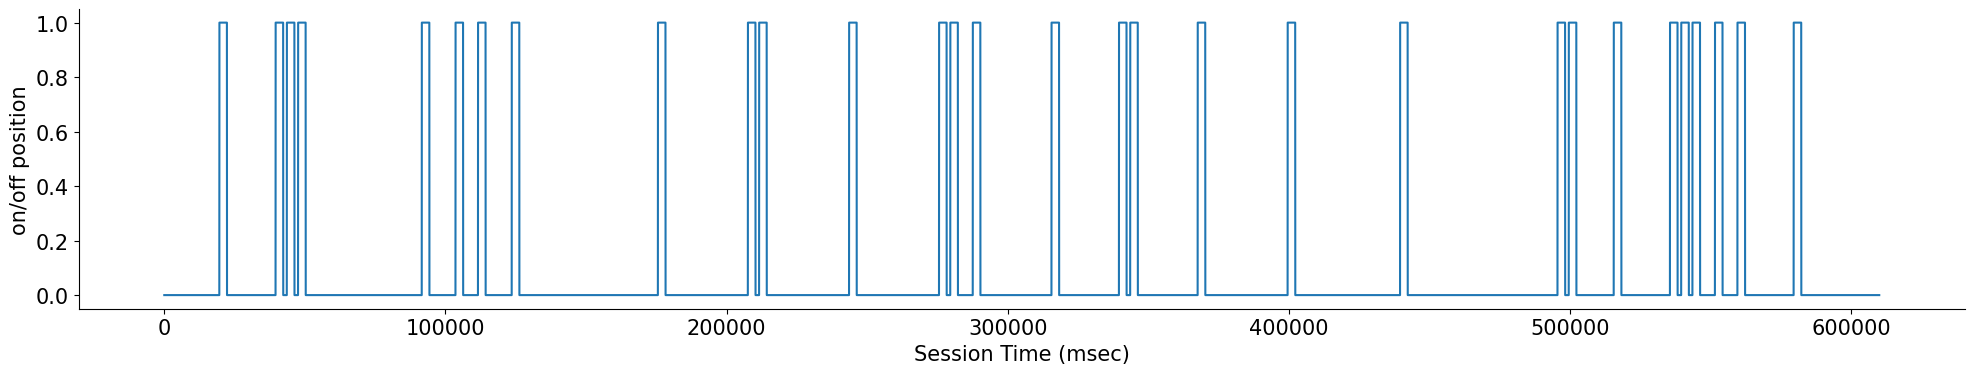

In [ ]:
id_num = 0
value = 0
for i, v in enumerate(v_m_on):
  if i in t_m_on:
    value = (dat['stim_id'][id_num])
    id_num += 1
  if i in t_m_off:
    value = 0
  v_m_on[i] = value

v_m_on_fingers = np.zeros((dig+1, np.shape(v_m_on)[0]))
for i in range(dig+1):
  v_m_on_fingers[i, :] = (v_m_on == (i + 1))
#plt.figure(figsize=(20, 20))
for i in range(dig+1):
  ax = plt.subplot(dig+1, 1, i + 1)
  plt.plot(v_m_on_fingers[i])
plt.xlabel('Session Time (msec)')
plt.ylabel('on/off position')


Text(0, 0.5, 'on/off position vs finger movemen')

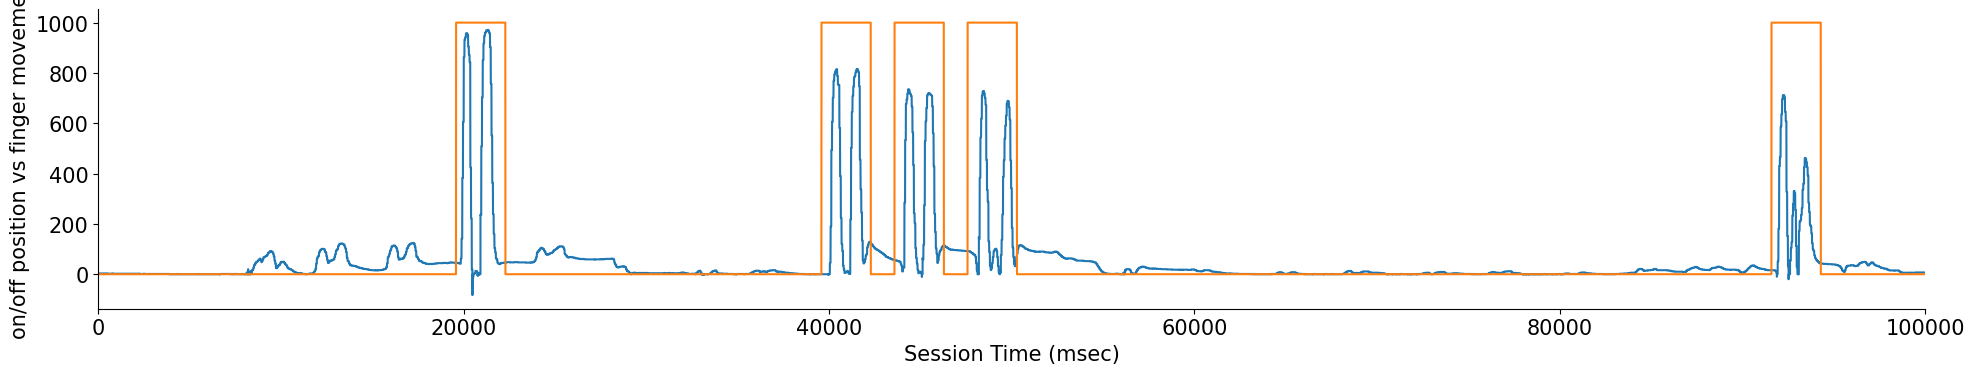

In [ ]:
#@title adjusting the time window
plt.plot(dg[:, dig])
plt.plot(v_m_on_fingers[dig]*1000)
plt.xlim(0, 100000)
plt.xlabel('Session Time (msec)')
plt.ylabel('on/off position vs finger movemen')

Text(0, 0.5, 'finger movement (chunks)')

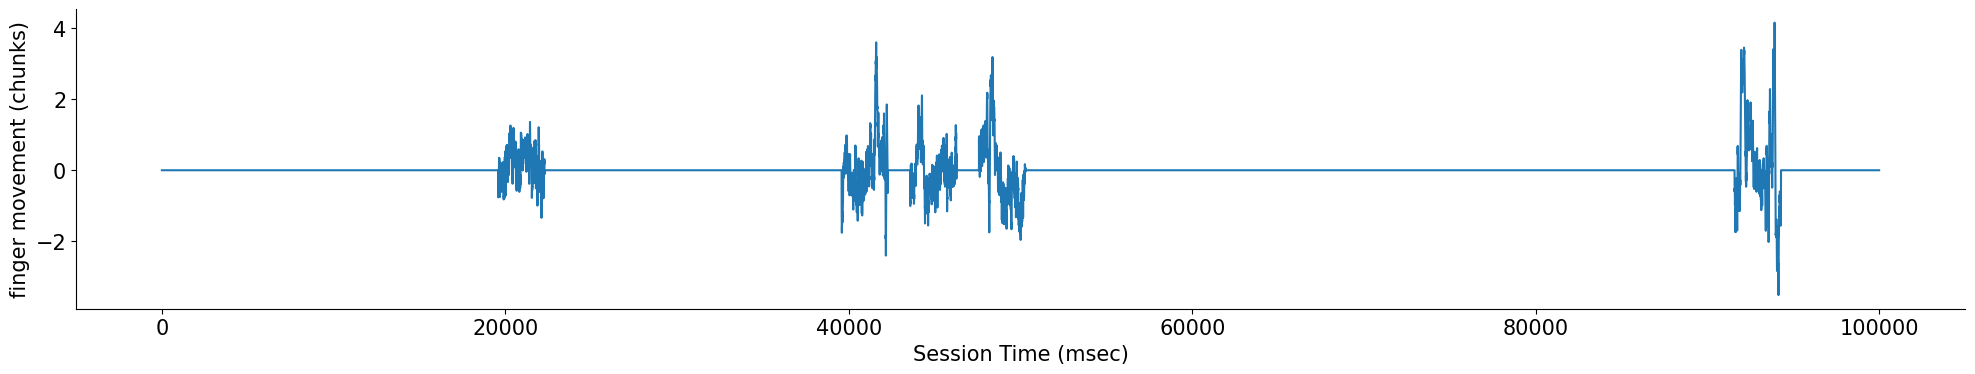

In [ ]:
result_list = []
for i in range(dig+1):
  V_on = V_raw[:, ch]*v_m_on_fingers[i]
  result_list.append(V_on)
  #plt.plot(V_on[:100000])

for i in range(dig + 1):
    V_on = result_list[i]
    plt.plot(V_on[:100000], label=f"V_on_{i}")

plt.xlabel('Session Time (msec)')
plt.ylabel('finger movement (chunks)')
#sharp edges might be problematic later, prbbl we should 'tape' the edges using a Gaussian or whtvr


**T_OFF_M  REST**

In [ ]:
v_r_on = np.zeros_like(V_raw[:, ch])
v_r_off = np.zeros_like(V_raw[:, ch])
value = True
t_r_on = [(t_on[i]) for i in range(len(t_on) - 1)]
t_r_off = [(t_off[i] + 2000) for i in range(len(t_off))]
for i, v in enumerate(v_r_on):
  if i in t_r_on:
    value = True
  if i in t_r_off:
    value = False
  v_r_on[i] = value

Text(0, 0.5, 'on/off position')

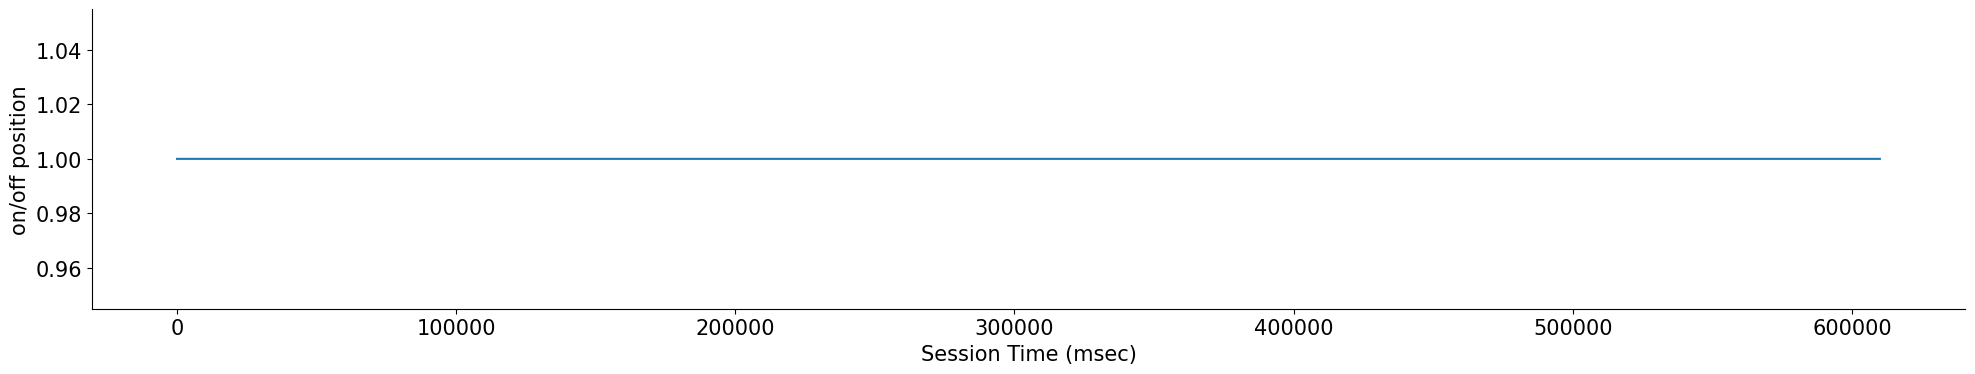

In [ ]:
id_num = 0
value = 0
for i, v in enumerate(v_r_on):
  if i in t_r_on:
    value = (dat['stim_id'][id_num])
    id_num += 1
  if i in t_r_off:
    value = 0
  v_r_on[i] = value

v_r_on_fingers = np.zeros((dig+1, np.shape(v_r_on)[0]))
v_r_off_fingers = np.zeros((dig+1, np.shape(v_r_on)[0]))
for i in range(dig+1):
  v_r_on_fingers[i, :] = (v_r_on == (i + 1))
#plt.figure(figsize=(20, 20))
for i in range(dig+1):
  ax = plt.subplot(dig+1, 1, i + 1)
  v_r_off_fingers[i] = abs(v_r_on_fingers[i] - 1)
  plt.plot(v_r_off_fingers[i])
plt.xlabel('Session Time (msec)')
plt.ylabel('on/off position')


Inversion 0-1 part: ✔

Text(0, 0.5, 'on/off position vs finger movemen')

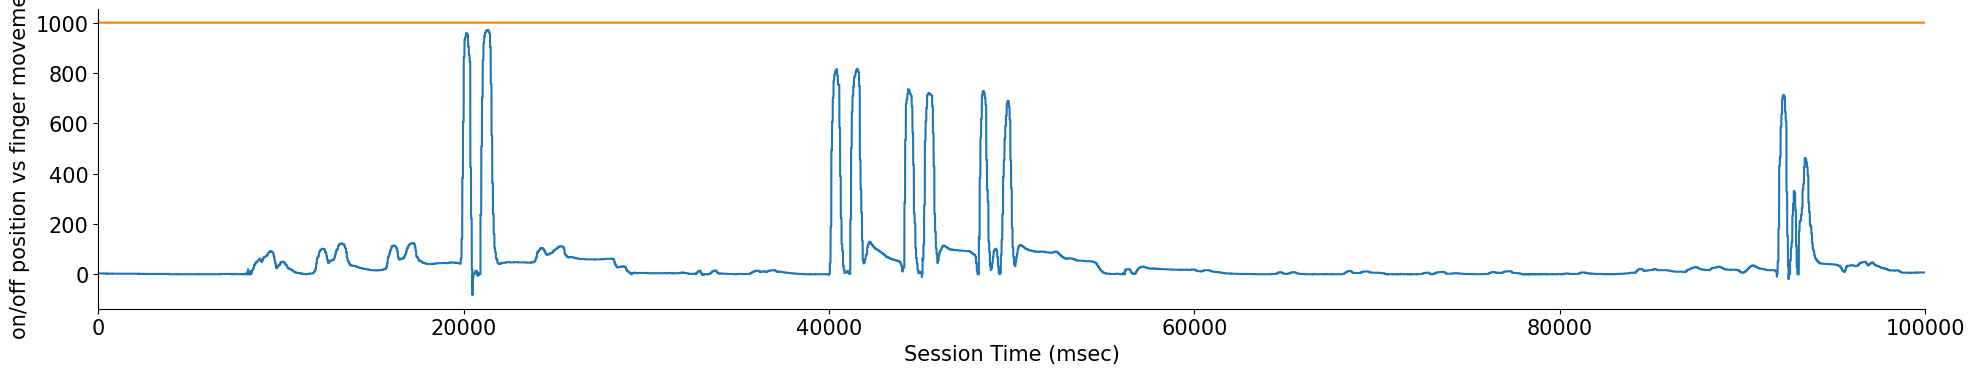

In [ ]:
#@title adjusting the time window
plt.plot(dg[:, dig])
plt.plot(v_r_off_fingers[dig]*1000)
plt.xlim(0, 100000)
plt.xlabel('Session Time (msec)')
plt.ylabel('on/off position vs finger movemen')

Text(0, 0.5, 'finger movement (chunks)')

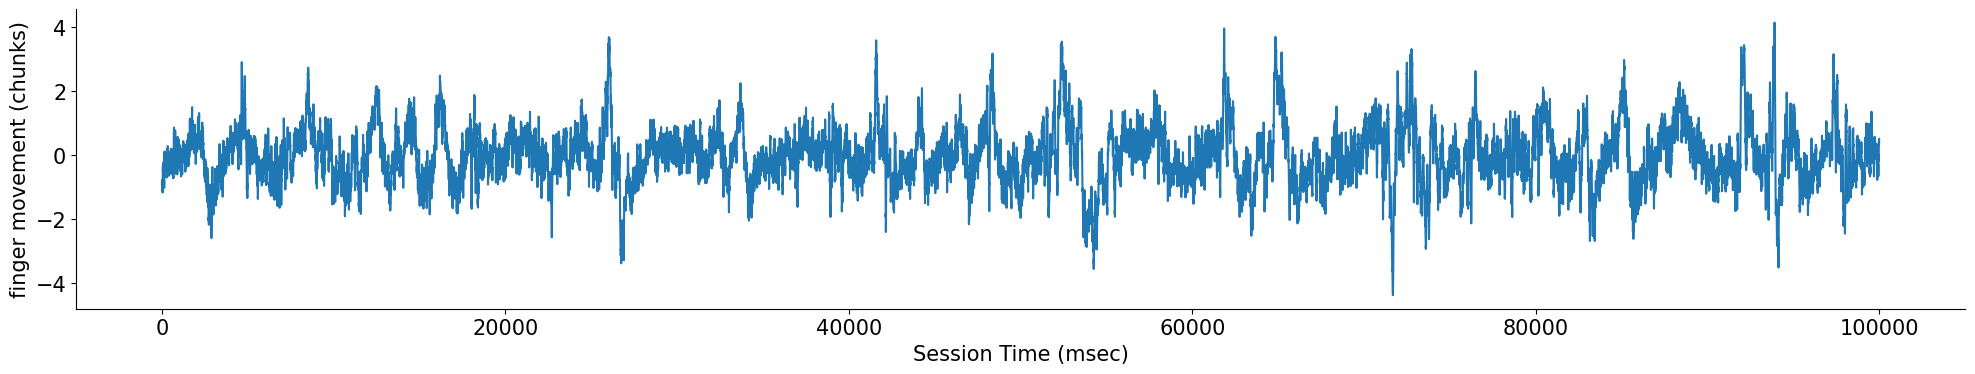

In [ ]:
result_list = []
for i in range(dig+1):
  V_on = V_raw[:, ch]*v_r_off_fingers[i]
  result_list.append(V_on)
  #plt.plot(V_on[:100000])

for i in range(dig + 1):
    V_on = result_list[i]
    plt.plot(V_on[:100000], label=f"V_off_{i}")

plt.xlabel('Session Time (msec)')
plt.ylabel('finger movement (chunks)')

Text(0.5, 1.0, 'Trial number 2')

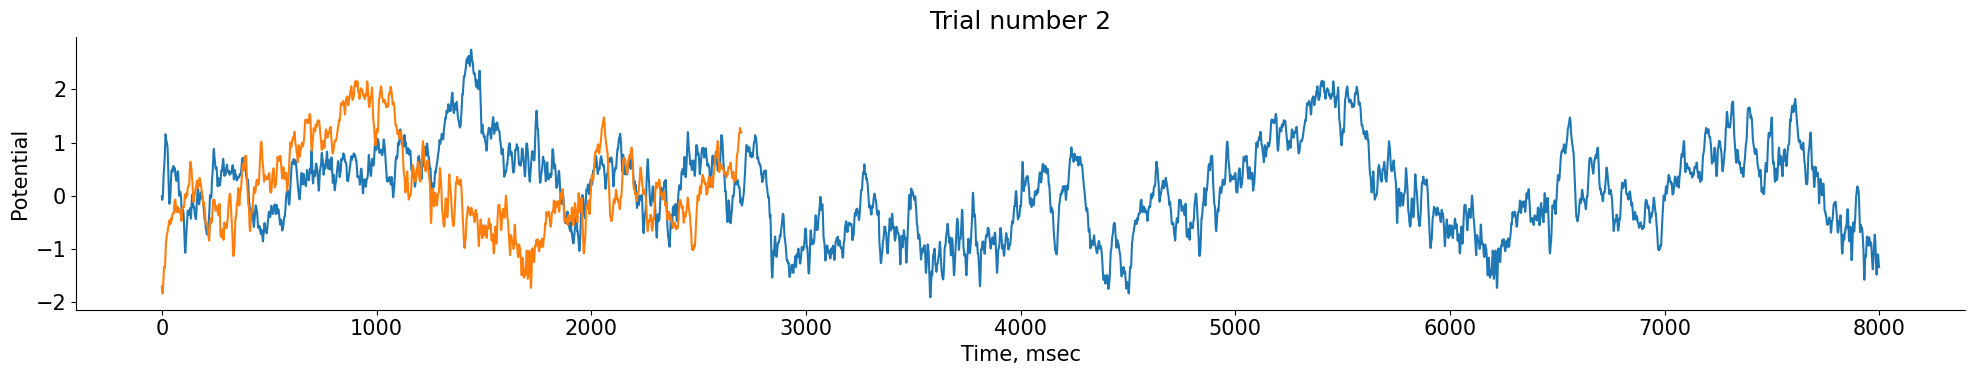

In [ ]:
trial_num = 1
plt.plot(V_raw[t_r_on[trial_num - 1]:t_r_off[trial_num], ch])
plt.plot(V_raw[t_m_on[trial_num]:t_m_off[trial_num], ch])
plt.xlabel('Time, msec')
plt.ylabel('Potential')
plt.title(f'Trial number {trial_num + 1}')

In [ ]:
t_rest_on = []
t_rest_off = []
for i in range(len(t_r_on) - 1):
  if (t_r_off[i+1] - t_r_on[i]) >=2000:
    t_rest_on.append(t_r_on[i])
    t_rest_off.append(t_r_off[i])
print(t_r_on)
print(t_rest_on)
print(t_r_off)
print(len(t_rest_on))
print(len(t_rest_off))
trial_num = 148

[7080, 11080, 15080, 19080, 23080, 27080, 31080, 35080, 39080, 43080, 47080, 51080, 55080, 59080, 63080, 67080, 71080, 75080, 79080, 83080, 87080, 91080, 95080, 99080, 103080, 107080, 111080, 115080, 119080, 123080, 127080, 131080, 135080, 139080, 143080, 147080, 151080, 155080, 159080, 163080, 167080, 171080, 175080, 179080, 183080, 187080, 191080, 195080, 199080, 203080, 207080, 211080, 215080, 219080, 223080, 227080, 231080, 235080, 239080, 243080, 247080, 251080, 255080, 259080, 263080, 267080, 271080, 275080, 279080, 283080, 287080, 291080, 295080, 299080, 303080, 307080, 311080, 315080, 319080, 323080, 327080, 331080, 335080, 339080, 343080, 347080, 351080, 355080, 359080, 363080, 367080, 371080, 375080, 379080, 383080, 387080, 391080, 395080, 399080, 403080, 407080, 411080, 415080, 419080, 423080, 427080, 431080, 435080, 439080, 443080, 447080, 451080, 455080, 459080, 463080, 467080, 471080, 475080, 479080, 483080, 487080, 491080, 495080, 499080, 503080, 507080, 511080, 515080, 

(0.0, 200.0)

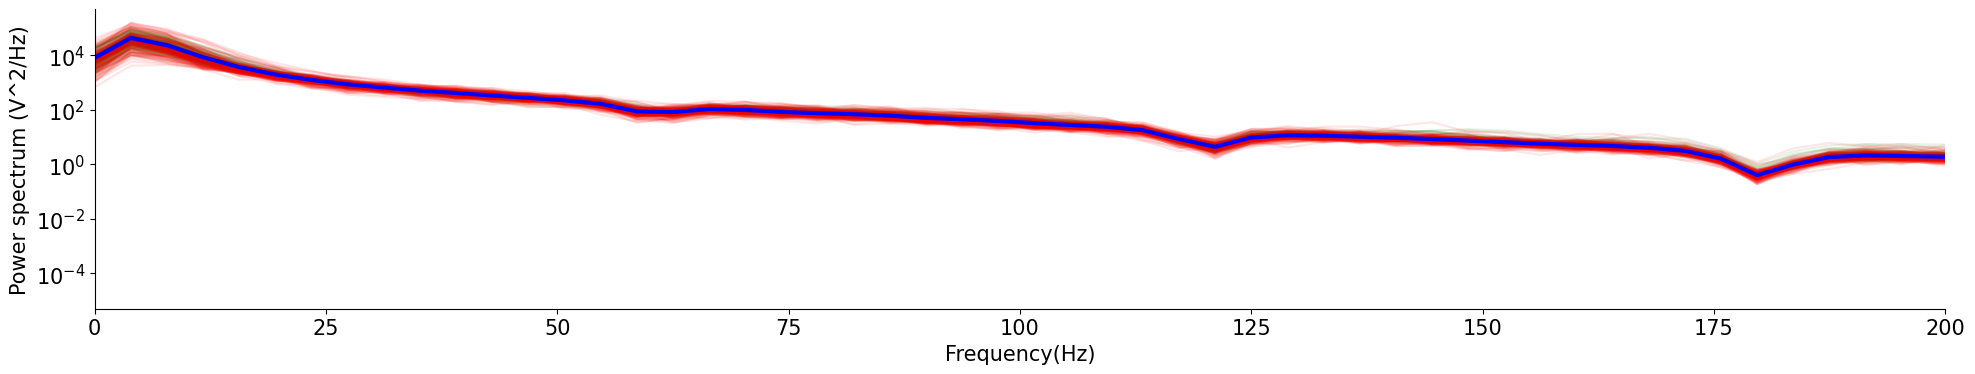

In [ ]:
trials = trial_num + 1
All_S = np.zeros((trials, 129))
print()

for cur_trial in range(2,trials):
  V_trial = V_raw[t_r_on[cur_trial - 1]:t_r_off[cur_trial], ch]
  #plt.plot(V_trial)
  #V_hat = fft(V_trial)
  (f, S)= signal.welch(V_trial*1000, fs=1000)
  All_S[cur_trial, :] = S
  plt.semilogy(f, S, 'g', alpha=0.1)
  #All_S=np.(S, All_S, axis=0)
Mean_S = np.mean(All_S, axis=0)
plt.plot(f, Mean_S, linewidth =3, color ='b')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Power spectrum (V^2/Hz)')

trials = len(t_m_on)
All_S = np.zeros((trials, 129))
print()

for cur_trial in range(trials):
  V_trial = V_raw[t_m_on[cur_trial]:t_m_off[cur_trial], ch]
  #V_hat = fft(V_trial)
  (f, S)= signal.welch(V_trial*1000, fs=1000)
  All_S[cur_trial, :] = S
  plt.semilogy(f, S, 'red', alpha=0.1)
  #All_S=np.(S, All_S, axis=0)
Mean_S = np.mean(All_S, axis=0)
plt.plot(f, Mean_S, linewidth =3, color ='b')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Power spectrum (V^2/Hz)')
plt.xlim(0, 200)
plt.xlim(0, 200)
#plt.ylim(1, 1e5 )

__Hilbert transform (though I have to get the appropriate data chunks first)__

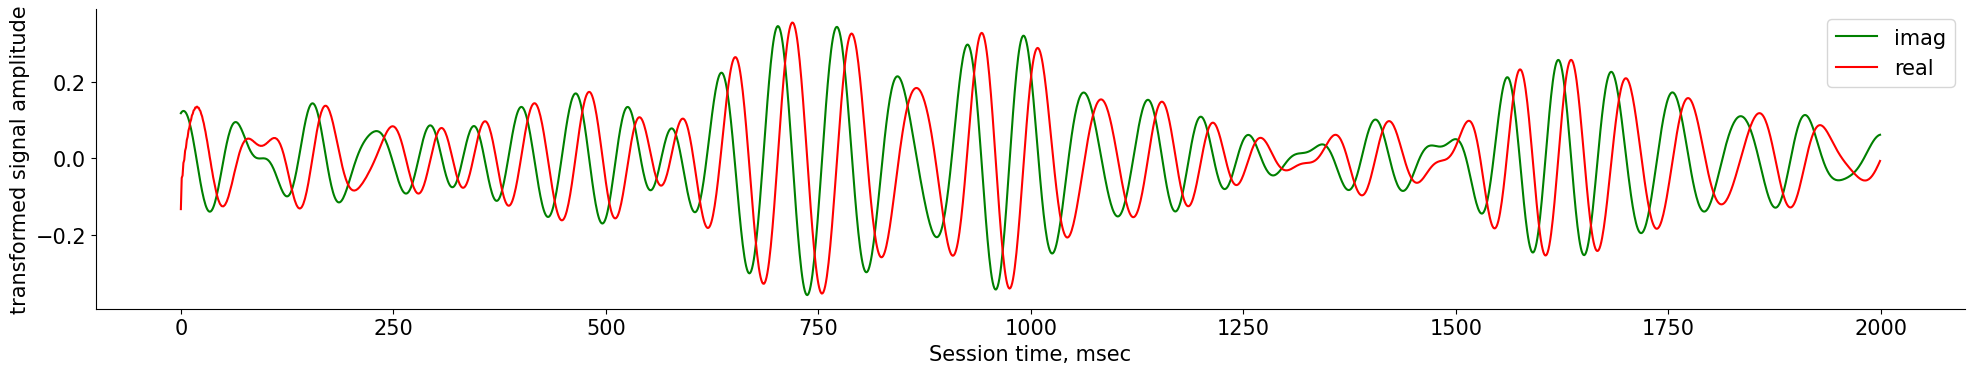

In [ ]:
t = 2000
V_bp_hilb = signal.hilbert(V_m_bp[:, ch])
imag = np.imag(V_bp_hilb)
real = np.real(V_bp_hilb)
plt.plot(real[:t], 'g')
plt.plot(imag[:t], 'r')
plt.xlabel('Session time, msec')
plt.ylabel('transformed signal amplitude')
plt.legend(['imag', 'real'],  loc='best')

In [ ]:
amplitude_envelope = np.abs(V_bp_hilb)
instantaneous_phase = np.unwrap(np.angle(V_bp_hilb))
instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)

Text(0, 0.5, 'amplitude envelope')

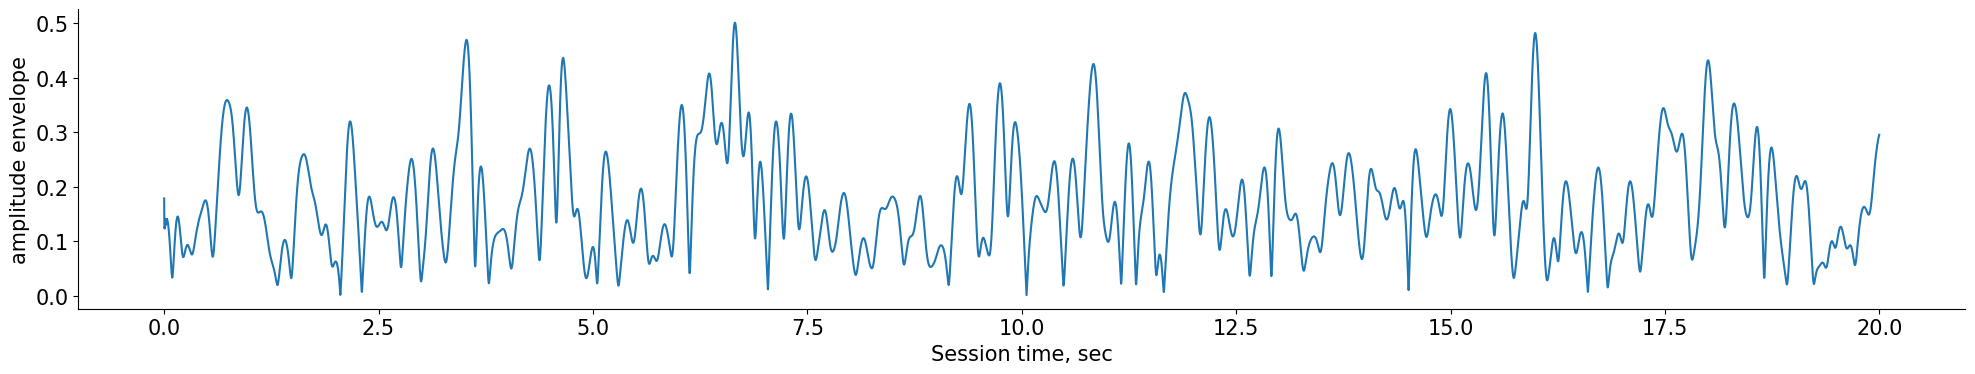

In [ ]:
time_axis = np.arange(len(amplitude_envelope[:20000]))/fs  # JR messing with your code
plt.plot(time_axis, amplitude_envelope[:20000])
plt.xlabel('Session time, sec')
plt.ylabel('amplitude envelope')

Text(0, 0.5, 'instantaneous_phase')

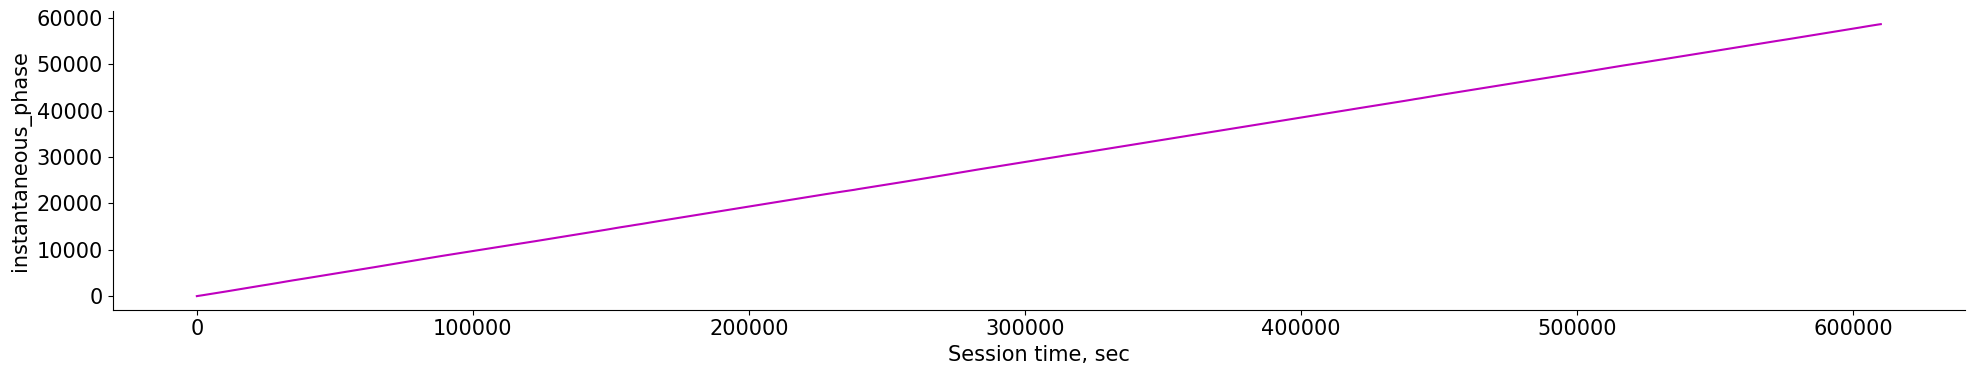

In [ ]:
plt.plot(instantaneous_phase, 'm') # have to make it look better
plt.xlabel('Session time, sec')
plt.ylabel('instantaneous_phase')

Text(0.5, 0, 'Time')

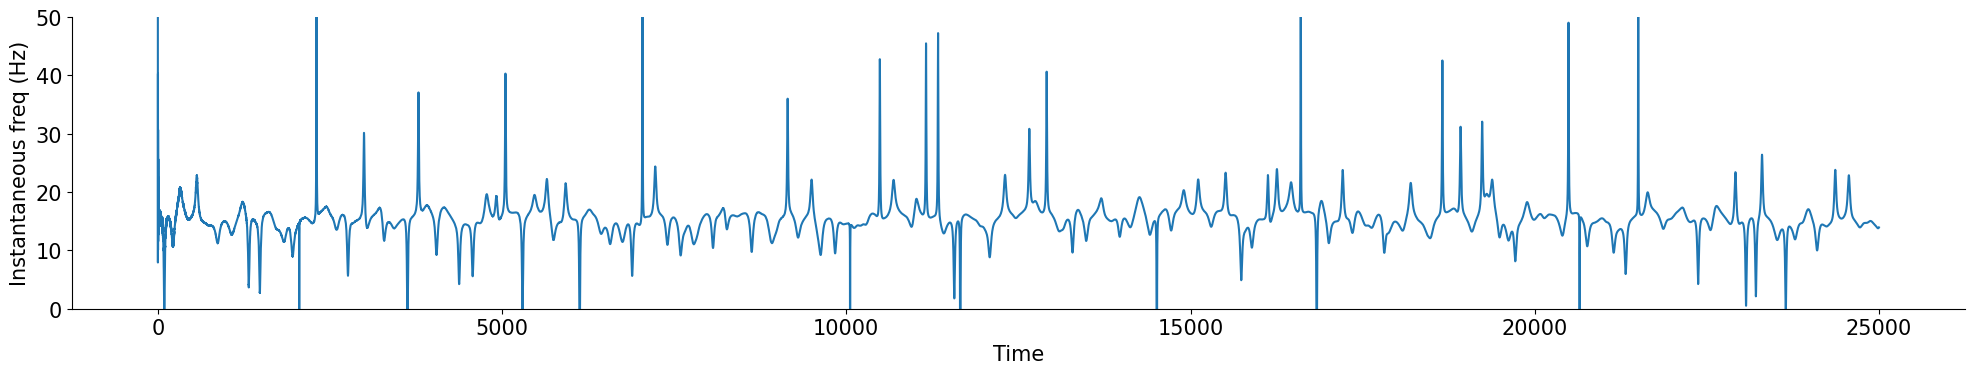

In [ ]:
plt.plot(instantaneous_frequency[:25000])
plt.ylim([0,50]) # Limit to meaningful frequency range
plt.ylabel('Instantaneous freq (Hz)')
plt.xlabel('Time')

Separating Finger Movements

In [ ]:


def split_into_chunks(lst, num_chunks):
    avg_chunk_size = len(lst) // num_chunks
    remainder = len(lst) % num_chunks

    chunks = []
    start_idx = 0

    for i in range(num_chunks):
        end_idx = start_idx + avg_chunk_size + (1 if i < remainder else 0)
        chunks.append(lst[start_idx:end_idx])
        start_idx = end_idx

    return chunks


t_m_on
num_chunks = 100
result_chunks = split_into_chunks(t_m_on, num_chunks)
print(result_chunks,)


[[7580, 11580], [15580, 19580], [23580, 27580], [31580, 35580], [39580, 43580], [47580, 51580], [55580, 59580], [63580, 67580], [71580, 75580], [79580, 83580], [87580, 91580], [95580, 99580], [103580, 107580], [111580, 115580], [119580, 123580], [127580, 131580], [135580, 139580], [143580, 147580], [151580, 155580], [159580, 163580], [167580, 171580], [175580, 179580], [183580, 187580], [191580, 195580], [199580, 203580], [207580, 211580], [215580, 219580], [223580, 227580], [231580, 235580], [239580, 243580], [247580, 251580], [255580, 259580], [263580, 267580], [271580, 275580], [279580, 283580], [287580, 291580], [295580, 299580], [303580, 307580], [311580, 315580], [319580, 323580], [327580, 331580], [335580, 339580], [343580, 347580], [351580, 355580], [359580, 363580], [367580, 371580], [375580, 379580], [383580, 387580], [391580, 395580], [399580, 403580], [407580], [411580], [415580], [419580], [423580], [427580], [431580], [435580], [439580], [443580], [447580], [451580], [455